<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/group_svm/Group_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metrics for Young Adult and Adolescent
- We will cover Whole Brain and sub-region masks
- Confusion Matrix 
- Precision-Recall-AUC
- ROC-AUC scores

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')#, force_remount = True)

# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/group_svm
!ls

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
# Import libraries
!pip install boto3 nilearn
import pickle
from process import *
from access_data import *

from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt
import pandas as pd

## Get Metric data for all masks

In [55]:
%%time

metric_ya_dict = {}
mask_types = ['mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC']
group = "Young Adult" # "Adolescent", "Young Adult"
data_type = 'YA_detrend' # "YA_detrend" , "AD_detrend"
runs = [1, 2]
runs_id = [i+1 for i in runs]

for mask_type in mask_types:
  print(f"Loading and saving {mask_type} for {group}...")

  # Define directories where metrics and models are stored on AWS
  metric_directory = f'metrics/group_svm/{mask_type}/'
  metric_path = f'{data_type}_{runs_id}_{mask_type}_metrics.pkl'

  metrics_ya = access_load_data(f'{metric_directory}{metric_path}', False)

  metric_ya_dict[mask_type] = metrics_ya

Loading and saving mask for Young Adult...
Loading and saving masksubACC for Young Adult...
Loading and saving masksubAI for Young Adult...
Loading and saving masksubNAcc for Young Adult...
Loading and saving masksubmPFC for Young Adult...
CPU times: user 1.23 s, sys: 123 ms, total: 1.35 s
Wall time: 25.8 s


## Confusion Matrix


In [206]:
# Load Young Adult Whole Brain Mask and Adolescent Whole Brain Mask metrics data

mask_type = 'mask'
data_type1 = 'AD_detrend'
data_type2 = 'YA_detrend'
runs = [1, 2]
runs_id = [i+1 for i in runs]

# Define directories where metrics and models are stored on AWS
metric_directory1 = f'metrics/group_svm/{mask_type}/'
metric_path1 = f'{data_type1}_{runs_id}_{mask_type}_metrics.pkl'

metric_directory2 = f'metrics/group_svm/{mask_type}/'
metric_path2 = f'{data_type2}_{runs_id}_{mask_type}_metrics.pkl'

metrics_ad = access_load_data(f'{metric_directory1}{metric_path1}', False)
metrics_ya = access_load_data(f'{metric_directory2}{metric_path2}', False)
print(metrics_ad.keys())

dict_keys(['bmap3', 'bmap2_3', 'alphas1', 'bmap', 'y_train', 'test_preds', 'test_probs', 'test_acc', 'test_dfunc', 'y_t'])


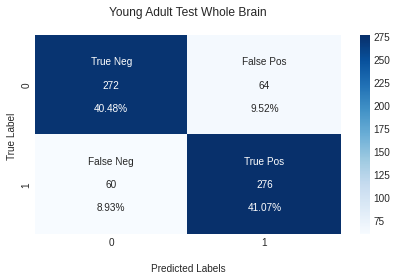

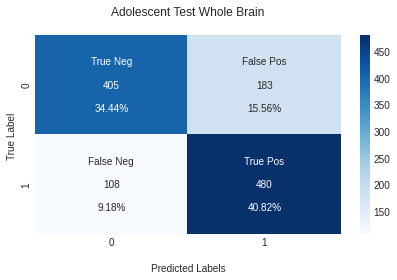

In [208]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm_t = confusion_matrix(metrics_ya['y_t'][0], metrics_ya['test_preds'][0])

cm_tad = confusion_matrix(metrics_ad['y_t'][0], metrics_ad['test_preds'][0])

cm_mat = [(cm_t, 'Test', "Young Adult"), 
          (cm_tad, 'Test', "Adolescent")]

if mask_type == "mask":
  mask_type = "Whole Brain"

for cm, name, group_type in cm_mat:
  rate_names = ['True Neg','False Pos','False Neg','True Pos']

  rate_values = ["{0:0}".format(value) for value in cm.flatten()]

  percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

  labels = [f"{val1}\n\n{val2}\n\n{val3}" for val1, val2, val3 in
            zip(rate_names,rate_values,percentages)]

  labels = np.asarray(labels).reshape(2,2)

  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

  #plt.figure(figsize=(8,8))
  # Change the style of plot
  plt.style.use('seaborn-darkgrid')
  ax.set_title(f'{group_type} {name} {mask_type}\n');
  ax.set_xlabel('\nPredicted Labels')
  ax.set_ylabel('True Label ');

  plt.tight_layout()
  plt.savefig(f'/content/gdrive/MyDrive/{group_type}_{name}_{mask_type}_Conf matrix', dpi = 200)
  plt.show()

## Precision Recall
- Each Young Adult Mask
- Each Adolescent Mask
- Young Adult and Adolescent

Adolescent Whole Brain SVM: f1=76.739% auc=81.83% 

Adolescent without Anterior Cingulate Cortex SVM: f1=75.862% auc=83.234% 

Adolescent without Anterior Insula SVM: f1=75.923% auc=82.151% 

Adolescent without Nucleus Accumbens SVM: f1=77.023% auc=81.955% 

Adolescent without Medial Prefontal Cortex SVM: f1=75.426% auc=82.279% 



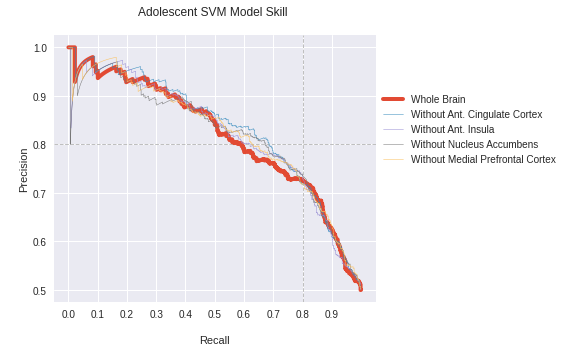

In [96]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

fig = plt.figure(figsize = (8, 5))

# Change the style of plot
plt.style.use('seaborn-darkgrid')

# YA mask
mask_pr, mask_re, _ = precision_recall_curve(metric_ya_dict['mask']['y_t'][0], 
                                             metric_ya_dict['mask']['test_probs'][0]
                                             )
mask_f1, mask_auc = f1_score(metric_ya_dict['mask']['y_t'][0], metric_ya_dict['mask']['test_preds'][0]), auc(mask_re, mask_pr)

# YA subACC
subacc_pr, subacc_re, _ = precision_recall_curve(metric_ya_dict['masksubACC']['y_t'][0], 
                                                 metric_ya_dict['masksubACC']['test_probs'][0]
                                                )
subacc_f1, subacc_auc = f1_score(metric_ya_dict['masksubACC']['y_t'][0], metric_ya_dict['masksubACC']['test_preds'][0]), auc(subacc_re, subacc_pr)

# YA subAI
subai_pr, subai_re, _ = precision_recall_curve(metric_ya_dict['masksubAI']['y_t'][0], 
                                               metric_ya_dict['masksubAI']['test_probs'][0]
                                              )
subai_f1, subai_auc = f1_score(metric_ya_dict['masksubAI']['y_t'][0], metric_ya_dict['masksubAI']['test_preds'][0]), auc(subai_re, subai_pr)

# YA subNAcc
subnac_pr, subnac_re, _ = precision_recall_curve(metric_ya_dict['masksubNAcc']['y_t'][0], 
                                                 metric_ya_dict['masksubNAcc']['test_probs'][0]
                                                )
subnac_f1, subnac_auc = f1_score(metric_ya_dict['masksubNAcc']['y_t'][0], metric_ya_dict['masksubNAcc']['test_preds'][0]), auc(subnac_re, subnac_pr)

# YA submPFC
subpfc_pr, subpfc_re, _ = precision_recall_curve(metric_ya_dict['masksubmPFC']['y_t'][0], 
                                                 metric_ya_dict['masksubmPFC']['test_probs'][0]
                                                )
subpfc_f1, subpfc_auc = f1_score(metric_ya_dict['masksubmPFC']['y_t'][0], metric_ya_dict['masksubmPFC']['test_preds'][0]), auc(subpfc_re, subpfc_pr)
                             
if group == "Young Adult":
  # summarize scores
  print(f'Young Adult Whole Brain SVM: f1={mask_f1 * 100:{.5}}% auc={mask_auc* 100:{.5}}% \n')
  print(f'Young Adult without Anterior Cingulate Cortex SVM: f1={subacc_f1* 100:{.5}}% auc={subacc_auc* 100:{.5}}% \n')
  print(f'Young Adult without Anterior Insula SVM: f1={subai_f1* 100:{.5}}% auc={subai_auc* 100:{.5}}% \n')
  print(f'Young Adult without Nucleus Accumbens SVM: f1={subnac_f1* 100:{.5}}% auc={subnac_auc* 100:{.5}}% \n')
  print(f'Young Adult without Medial Prefontal Cortex SVM: f1={subpfc_f1* 100:{.5}}% auc={subpfc_auc* 100:{.5}}% \n')
elif group == "Adolescent":
  # summarize scores
  print(f'Adolescent Whole Brain SVM: f1={mask_f1 * 100:{.5}}% auc={mask_auc* 100:{.5}}% \n')
  print(f'Adolescent without Anterior Cingulate Cortex SVM: f1={subacc_f1* 100:{.5}}% auc={subacc_auc* 100:{.5}}% \n')
  print(f'Adolescent without Anterior Insula SVM: f1={subai_f1* 100:{.5}}% auc={subai_auc* 100:{.5}}% \n')
  print(f'Adolescent without Nucleus Accumbens SVM: f1={subnac_f1* 100:{.5}}% auc={subnac_auc* 100:{.5}}% \n')
  print(f'Adolescent without Medial Prefontal Cortex SVM: f1={subpfc_f1* 100:{.5}}% auc={subpfc_auc* 100:{.5}}% \n')

y_t = metric_ya_dict['mask']['y_t'][0]
# plot the precision-recall curves
#random = len(y_t[y_t==1]) / len(y_t) #create line of 50-50 split
#plt.plot([0, 1], [random, random], linestyle='--', label='Chance')
plt.axhline(0.8, c='gray', ls="--", lw=1, alpha=0.5)
plt.axvline(0.8, c='gray', ls="--", lw=1, alpha=0.5)
plt.xticks(np.arange(0.0, 1.0, 0.1))
ax.yaxis.set_ticks(np.arange(0.0, 1.0, 0.1))

#YA or AD
plt.plot(mask_re, mask_pr, marker='', label='Whole Brain', color = '#e24a33', lw = 4)
plt.plot(subacc_re,subacc_pr,  marker='', label='Without Ant. Cingulate Cortex', color = "#348abd", lw = 0.5)
plt.plot(subai_re,subai_pr, marker='', label='Without Ant. Insula', color = "#988ed5", lw = .5)
plt.plot(subnac_re,subnac_pr, marker='', label='Without Nucleus Accumbens', color = "#777777", lw = .5)
plt.plot(subpfc_re,subpfc_pr, marker='', label='Without Medial Prefrontal Cortex', color = "#fbc15e", lw = .5)

# axis labels
plt.xlabel('\nRecall')
plt.ylabel('\nPrecision')
if group == "Young Adult":
  plt.title("Young Adult SVM Model Skill \n")
elif group == "Adolescent":
  plt.title("Adolescent SVM Model Skill \n")

# show the legend
#plt.legend(loc = "lower left")
lgd = plt.legend(loc=(1.01, 0.5))
if group == 'Young Adult':
  plt.savefig(f'/content/gdrive/MyDrive/YA_viz_notebook/YA_models_Precision_Recall_1.png', 
              dpi =200,
              bbox_extra_artists=(lgd,), 
              bbox_inches='tight')
elif group == 'Adolescent':
  plt.savefig(f'/content/gdrive/MyDrive/ADOL/AD_models_Precision_Recall_1.png', 
              dpi =200,
              bbox_extra_artists=(lgd,), 
              bbox_inches='tight')
plt.tight_layout()

> Compare Young Adult and Adolescent

In [40]:
# Load Young Adult Whole Brain Mask and Adolescent Whole Brain Mask metrics data

mask_type = 'mask'
data_type1 = 'AD_detrend'
data_type2 = 'YA_detrend'
runs = [1, 2]
runs_id = [i+1 for i in runs]

# Define directories where metrics and models are stored on AWS
metric_directory1 = f'metrics/group_svm/{mask_type}/'
metric_path1 = f'{data_type1}_{runs_id}_{mask_type}_metrics.pkl'

metric_directory2 = f'metrics/group_svm/{mask_type}/'
metric_path2 = f'{data_type2}_{runs_id}_{mask_type}_metrics.pkl'

metrics_ad = access_load_data(f'{metric_directory1}{metric_path1}', False)
metrics_ya = access_load_data(f'{metric_directory2}{metric_path2}', False)

> Build the Precision Recall Curve

Young Adult Whole Brain: f1=81.657% auc=90.219% 

Adolescent Whole Brain: f1=76.739% auc=81.83% 



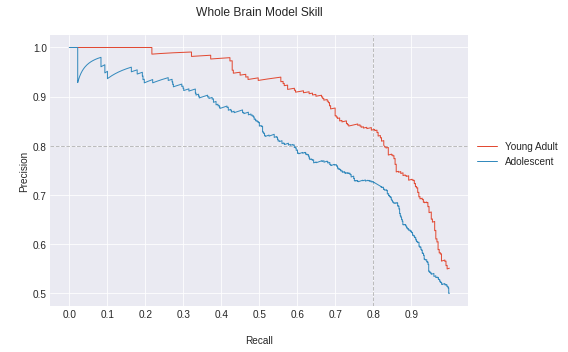

In [16]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

fig = plt.figure(figsize = (8, 5))

# Change the style of plot
plt.style.use('seaborn-darkgrid')

# YA mask
ya_pr, ya_re, _ = precision_recall_curve(metrics_ya['y_t'][0], 
                                         metrics_ya['test_probs'][0]
                                        )
ya_f1, ya_auc = f1_score(metrics_ya['y_t'][0], metrics_ya['test_preds'][0]), auc(ya_re, ya_pr)

# AD mask
ad_pr, ad_re, _ = precision_recall_curve(metrics_ad['y_t'][0], 
                                         metrics_ad['test_probs'][0]
                                        )
ad_f1, ad_auc = f1_score(metrics_ad['y_t'][0], metrics_ad['test_preds'][0]), auc(ad_re, ad_pr)

# summarize scores
print(f'Young Adult Whole Brain: f1={ya_f1 * 100:{.5}}% auc={ya_auc* 100:{.5}}% \n')
print(f'Adolescent Whole Brain: f1={ad_f1* 100:{.5}}% auc={ad_auc* 100:{.5}}% \n')
  
# Plot target lines
plt.axhline(0.8, c='gray', ls="--", lw=1, alpha=0.5)
plt.axvline(0.8, c='gray', ls="--", lw=1, alpha=0.5)
plt.xticks(np.arange(0.0, 1.0, 0.1))

#Plot precision-recall curves
plt.plot(ya_re, ya_pr, marker='', label='Young Adult', color = '#e24a33', lw = 1)
plt.plot(ad_re, ad_pr,  marker='', label='Adolescent', color = "#348abd", lw = 1)

# axis labels
plt.xlabel('\nRecall')
plt.ylabel('\nPrecision')
plt.title("Whole Brain Model Skill\n")

# show the legend
lgd = plt.legend(loc=(1.01, 0.5))
plt.savefig(f'/content/gdrive/MyDrive/YA_AD_Precision_Recall_1.png', 
            dpi =200,
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight'
            )
plt.tight_layout()

## ROC Curve

In [23]:
print("First level:", metric_ya_dict.keys())
print("Second level:", metric_ya_dict['mask'].keys())

First level: dict_keys(['mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'])
Second level: dict_keys(['bmap3', 'bmap2_3', 'alphas1', 'bmap', 'y_train', 'test_preds', 'test_probs', 'test_acc', 'test_dfunc', 'y_t'])


Adolescent SVM Whole Brain Model ROC AUC=81.127% 

Adolescent SVM without Anterior Circular Cortex Model ROC AUC=82.278% 

Adolescent SVM without Anterior Insula (Right) Model ROC AUC=81.361% 

Adolescent SVM without Nucleus Accumbens Model ROC AUC=81.853% 

Adolescent SVM without Medial Prefrontal Cortex Model ROC AUC=81.863% 



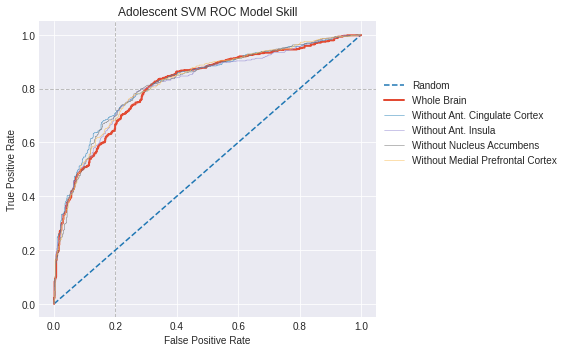

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve

# generate a no skill prediction (majority class)
y_t = metric_ya_dict['mask']['y_t'][0]
ns_probs = [0 for _ in range(len(y_t))]
ns_auc = roc_auc_score(y_t, ns_probs)

# calculate scores
#YA 
#mask
mask_auc = roc_auc_score(metric_ya_dict['mask']['y_t'][0], 
                        metric_ya_dict['mask']['test_probs'][0])
#subacc
acc_auc = roc_auc_score(metric_ya_dict['masksubACC']['y_t'][0], 
                        metric_ya_dict['masksubACC']['test_probs'][0])
#subai
ai_auc = roc_auc_score(metric_ya_dict['masksubAI']['y_t'][0], 
                        metric_ya_dict['masksubAI']['test_probs'][0])
#subnacc
nacc_auc = roc_auc_score(metric_ya_dict['masksubNAcc']['y_t'][0], 
                        metric_ya_dict['masksubNAcc']['test_probs'][0])
#submpfc
mpfc_auc = roc_auc_score(metric_ya_dict['masksubmPFC']['y_t'][0], 
                        metric_ya_dict['masksubmPFC']['test_probs'][0])

# summarize scores
if group == "Young Adult":
  print(f'{group} SVM Whole Brain Model ROC AUC={mask_auc*100:{.5}}% \n')
  print(f'{group} SVM without Anterior Circular Cortex Model ROC AUC={acc_auc*100:{.5}}% \n')
  print(f'{group} SVM without Anterior Insula (Right) Model ROC AUC={ai_auc*100:{.5}}% \n')
  print(f'{group} SVM without Nucleus Accumbens Model ROC AUC={nacc_auc*100:{.5}}% \n')
  print(f'{group} SVM without Medial Prefrontal Cortex Model ROC AUC={mpfc_auc*100:{.5}}% \n')
elif group == "Adolescent":
  print(f'{group} SVM Whole Brain Model ROC AUC={mask_auc*100:{.5}}% \n')
  print(f'{group} SVM without Anterior Circular Cortex Model ROC AUC={acc_auc*100:{.5}}% \n')
  print(f'{group} SVM without Anterior Insula (Right) Model ROC AUC={ai_auc*100:{.5}}% \n')
  print(f'{group} SVM without Nucleus Accumbens Model ROC AUC={nacc_auc*100:{.5}}% \n')
  print(f'{group} SVM without Medial Prefrontal Cortex Model ROC AUC={mpfc_auc*100:{.5}}% \n')
  

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_t, ns_probs) # no skill

#mask
fpr_mask, tpr_mask, _ = roc_curve(metric_ya_dict['mask']['y_t'][0], 
                                  metric_ya_dict['mask']['test_probs'][0])
#subacc
fpr_acc, tpr_acc, _ = roc_curve(metric_ya_dict['masksubACC']['y_t'][0], 
                                metric_ya_dict['masksubACC']['test_probs'][0])
#subai
fpr_ai, tpr_ai, _ = roc_curve(metric_ya_dict['masksubAI']['y_t'][0], 
                              metric_ya_dict['masksubAI']['test_probs'][0])
#subnacc
fpr_nacc, tpr_nacc, _ = roc_curve(metric_ya_dict['masksubNAcc']['y_t'][0], 
                                  metric_ya_dict['masksubNAcc']['test_probs'][0])
#submpfc
fpr_mpfc, tpr_mpfc, _ = roc_curve(metric_ya_dict['masksubmPFC']['y_t'][0], 
                                  metric_ya_dict['masksubmPFC']['test_probs'][0])

# Change the style of plot
fig = plt.figure(figsize = (8, 5))
plt.style.use('seaborn-darkgrid')

# plot target lines
plt.axhline(0.8, c='gray', ls="--", lw=1, alpha=0.5)
plt.axvline(0.2, c='gray', ls="--", lw=1, alpha=0.5)

# plot the roc curve for the model

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
plt.plot(fpr_mask, tpr_mask, marker='', label='Whole Brain', color = '#e24a33', lw = 2)
plt.plot(fpr_acc, tpr_acc, marker='', label='Without Ant. Cingulate Cortex', color = "#348abd", lw = 0.5)
plt.plot(fpr_ai, tpr_ai, marker='', label='Without Ant. Insula', color = "#988ed5", lw = .5)
plt.plot(fpr_nacc, tpr_nacc, marker='', label='Without Nucleus Accumbens', color = "#777777", lw = .5)
plt.plot(fpr_mpfc, tpr_mpfc, marker='', label='Without Medial Prefrontal Cortex', color = "#fbc15e", lw = .5)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"{group} SVM ROC Model Skill")
lgd = plt.legend(loc=(1.01, 0.5))

if group == "Young Adult":
  plt.savefig(f'/content/gdrive/MyDrive/YA/{group}_ROC_1.png', 
              dpi =200,
              bbox_extra_artists=(lgd,), 
              bbox_inches='tight'
              )
elif group == "Adolescent":
  plt.savefig(f'/content/gdrive/MyDrive/ADOL/{group}_ROC_1.png', 
            dpi =200,
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight'
            )

plt.tight_layout()

>> Do Comparison of YA and AD

Young Adult SVM Whole Brain Model ROC AUC=89.297% 

Adolescent SVM without Anterior Circular Cortex Model ROC AUC=81.127% 



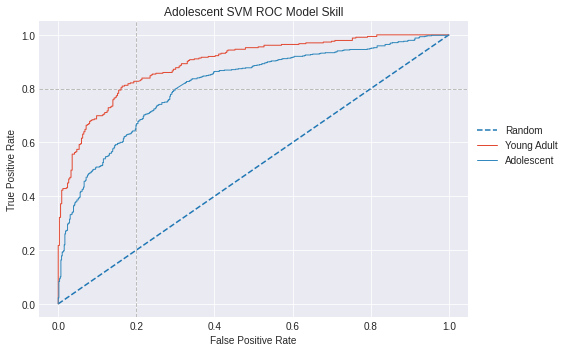

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve

# generate a no skill prediction (majority class)
y_t = metrics_ya['y_t'][0]
ns_probs = [0 for _ in range(len(y_t))]
ns_auc = roc_auc_score(y_t, ns_probs)

# calculate scores
#YA 
#mask
ya_auc = roc_auc_score(metrics_ya['y_t'][0], 
                        metrics_ya['test_probs'][0])
#subacc
ad_auc = roc_auc_score(metrics_ad['y_t'][0], 
                        metrics_ad['test_probs'][0])

# summarize scores
print(f'Young Adult SVM Whole Brain Model ROC AUC={ya_auc*100:{.5}}% \n')
print(f'Adolescent SVM without Anterior Circular Cortex Model ROC AUC={ad_auc*100:{.5}}% \n')
 

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_t, ns_probs) # no skill

#mask
fpr_ya, tpr_ya, _ = roc_curve(metrics_ya['y_t'][0], 
                                  metrics_ya['test_probs'][0])
#subacc
fpr_ad, tpr_ad, _ = roc_curve(metrics_ad['y_t'][0], 
                                metrics_ad['test_probs'][0])

# Change the style of plot
fig = plt.figure(figsize = (8, 5))
plt.style.use('seaborn-darkgrid')

# plot target lines
plt.axhline(0.8, c='gray', ls="--", lw=1, alpha=0.5)
plt.axvline(0.2, c='gray', ls="--", lw=1, alpha=0.5)

# plot the roc curve for the model

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
plt.plot(fpr_ya, tpr_ya, marker='', label='Young Adult', color = '#e24a33', lw = 1)
plt.plot(fpr_ad, tpr_ad, marker='', label='Adolescent', color = "#348abd", lw = 1)


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"{group} SVM ROC Model Skill")
lgd = plt.legend(loc=(1.01, 0.5))


plt.savefig(f'/content/gdrive/MyDrive/YA/YA_AD_ROC_1.png', 
          dpi =200,
          bbox_extra_artists=(lgd,), 
          bbox_inches='tight'
          )

plt.tight_layout()

>> Make metric chart

In [170]:
d = {'Young Adult Whole Brain': {'f1': 81.657, 'PR AUC':90.219, 'ROC AUC':89.297, 'Accuracy': 81.548},
     'Young Adult without Anterior Cingulate Cortex': {'f1':81.818, 'PR AUC':89.743, 'ROC AUC':88.778, 'Accuracy':81.548}, 
     'Young Adult without Anterior Insula': {'f1':81.121 ,'PR AUC':89.906, 'ROC AUC':89.0, 'Accuracy': 80.952},
     'Young Adult without Nucleus Accumbens': {'f1':81.536, 'PR AUC':90.107, 'ROC AUC':89.136, 'Accuracy':81.399},
     'Young Adult without Medial Prefontal Cortex': {'f1':81.818, 'PR AUC':89.917, 'ROC AUC':88.981, 'Accuracy':81.548},
     'Adolescent Whole Brain': {'f1': 76.739, 'PR AUC': 81.83, 'ROC AUC': 81.127, 'Accuracy':75.255}, 
     'Adolescent without Anterior Cingulate Cortex': {'f1': 75.862, 'PR AUC': 83.234, 'ROC AUC':82.278, 'Accuracy':74.405}, 
     'Adolescent without Anterior Insula': {'f1': 75.923, 'PR AUC': 82.151, 'ROC AUC': 81.361, 'Accuracy':74.490},
     'Adolescent without Nucleus Accumbens': {'f1': 77.023, 'PR AUC':81.955, 'ROC AUC':81.853,'Accuracy': 75.850}, 
     'Adolescent without Medial Prefontal Cortex': {'f1':75.426, 'PR AUC':82.279, 'ROC AUC':81.863, 'Accuracy':74.235}}

In [196]:
d = {'Young Adult Whole Brain': {'f1': '81.657%', 'PR AUC':'90.219%', 'ROC AUC':'89.297%', 'Accuracy': '81.548%'},
     'Young Adult without Anterior Cingulate Cortex': {'f1':'81.818%', 'PR AUC':'89.743%', 'ROC AUC':'88.778%', 'Accuracy':'81.548%'}, 
     'Young Adult without Anterior Insula': {'f1':'81.121%' ,'PR AUC':'89.906%', 'ROC AUC':'89.0%', 'Accuracy': '80.952%'},
     'Young Adult without Nucleus Accumbens': {'f1':'81.536%', 'PR AUC':'90.107%', 'ROC AUC':'89.136%', 'Accuracy':'81.399%'},
     'Young Adult without Medial Prefontal Cortex': {'f1':'81.818%', 'PR AUC':'89.917%', 'ROC AUC':'88.981%', 'Accuracy':'81.548%'},
     'Adolescent Whole Brain': {'f1': '76.739%', 'PR AUC': '81.83%', 'ROC AUC': '81.127%', 'Accuracy':'75.255%'}, 
     'Adolescent without Anterior Cingulate Cortex': {'f1': '75.862%', 'PR AUC': '83.234%', 'ROC AUC':'82.278%', 'Accuracy':'74.405%'}, 
     'Adolescent without Anterior Insula': {'f1': '75.923%', 'PR AUC': '82.151%', 'ROC AUC': '81.361%', 'Accuracy':'74.490%'},
     'Adolescent without Nucleus Accumbens': {'f1': '77.023%', 'PR AUC':'81.955%', 'ROC AUC':'81.853%','Accuracy': '75.850%'}, 
     'Adolescent without Medial Prefontal Cortex': {'f1':'75.426%', 'PR AUC':'82.279%', 'ROC AUC':'81.863%', 'Accuracy':'74.235%'}}

import pandas as pd
dd = pd.DataFrame(d)
dd1 = dd.T.reset_index()
dd1.rename(columns = {'index': 'models'}, inplace = True)
dd1= dd1[['models',	'f1',	'PR AUC']]


In [200]:
map_color = {"90.219%":'#f58518', "90.107%":"#f58518", "89.917%":"#f58518",
             "83.234%": "#f8a758", '82.151%':"#f8a758" , '82.279%': "#f8a758"}

dd1["color"] = dd1["PR AUC"].map(map_color)
dd1['color'] = dd1['color'].replace(np.nan,'#eaeaf2')
cols_to_show = ['models',	'f1',	'PR AUC']#,	'ROC AUC',	'Accuracy']

fill_color = []
n = len(dd1)
for col in cols_to_show:
    if col!='PR AUC':
      fill_color.append(['#eaeaf2']*n)
    else:
      print("hi")
      fill_color.append(dd1["color"].to_list())


hi


In [203]:
import plotly.graph_objects as go
import pandas as pd
#dd1['color'] = ['rgb(52, 204, 235)', 'rgb(52, 204, 235)', 'rgb(52, 204, 235)', 'rgb(52, 204, 235)']

fig = go.Figure(data=[go.Table(
    header=dict(values=list(cols_to_show),
                fill_color='#96c6e2',
                align='center'),
    cells=dict(values=[dd1.models, dd1.f1, dd1['PR AUC']],
               fill_color=fill_color,
               align='center'))
])
fig.update_layout(
    height=700,
    width = 700,
    title_x=0.5
)
fig.show()

>Fin